In [1]:
import numpy as np # scientific computations library (http://www.numpy.org/)
import tensorflow as tf # deep learning library (https://www.tensorflow.org/)
import cv2 # OpenCV computer vision library (https://opencv.org/)
import random
import itertools
import os # file operations
import math
import csv

from plot_utils import visualize_dataset
from img_utils import get_train_images, get_test_images, preprocess_images, transform_image

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

/home/alexandre/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
NUM_CLASSES = 43

curr_dirname =  os.getcwd()
project_root_dir = os.path.dirname(os.path.abspath(curr_dirname))
MODEL_EXPORT_DIR = os.path.join(project_root_dir, 'models/new')

In [7]:
class TrafficSignsClassifier:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_validation = None
        self.y_validation = None
        self.x_test = None
        self.y_test = None
        self.tf_classes     = list(range(NUM_CLASSES))
        self.tf_classes = np.asarray(self.tf_classes)


    def train_validation_test_split(self, train_images, train_labels,test_images, test_labels, split_size = 5):
        train_labels = np.array(train_labels, dtype=np.int8)
        train_labels = self.convert_to_one_hot(train_labels, NUM_CLASSES)
        test_labels = np.array(test_labels, dtype=np.int8)
        test_labels = self.convert_to_one_hot(test_labels, NUM_CLASSES)

        train_dataset_size = len(train_images)
        num_validation_images = int(train_dataset_size * split_size/100)
        is_for_training = np.ones(train_dataset_size, dtype=bool)
        validation_imgs_idx = np.random.choice(np.arange(train_dataset_size), num_validation_images, replace=False)
        is_for_training[validation_imgs_idx] = False

        self.x_train = train_images[is_for_training]
        self.y_train = train_labels[is_for_training]
        self.x_validation = train_images[~is_for_training]
        self.y_validation = train_labels[~is_for_training]
        self.x_test, self.y_test = test_images, test_labels

    def create_placeholders(self, nH, nW, nC, nY):

        X = tf.placeholder(tf.float32, shape=[None, nH, nW, nC], name="X")
        Y = tf.placeholder(tf.float32, shape=[None, nY], name="Y")
        keep_prob = tf.placeholder(tf.float32)

        return X, Y, keep_prob

    def initialize_parameters(self):
        W1 = tf.get_variable("W1", shape = [5, 5, 3, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
        W2 = tf.get_variable("W2", shape = [5, 5, 16, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
        W3 = tf.get_variable("W3", shape = [3, 3, 32, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
        W4 = tf.get_variable("W4", shape = [3, 3, 128, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

        return { "W1": W1, "W2":W2, "W3": W3, "W4": W4 }

    def forward_propagation(self, X, parameters, keep_prob):
        W1 = parameters["W1"]
        W2 = parameters["W2"]
        W3 = parameters["W3"]
        W4 = parameters["W4"]

        # Conv1 layer with stride 1 and same padding
        Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="VALID")

        # Relu
        A1 = tf.nn.relu(Z1)

        # Conv2 with stride 1 and same padding
        Z2 = tf.nn.conv2d(A1, W2, strides=[1,1,1,1], padding="VALID")

        # Relu
        A2 = tf.nn.relu(Z2)

        # max-pool Kernel[2X2] stride 2
        P1 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides = [1,2,2,1], padding="VALID")

        # Conv3 layer with stride 1 and same padding
        Z3 = tf.nn.conv2d(P1, W3, strides=[1,1,1,1], padding="VALID")

        # Relu
        A3 = tf.nn.relu(Z3)

        # Conv4 with stride 1 and same padding
        Z4= tf.nn.conv2d(A3, W4, strides=[1,1,1,1], padding="VALID")

        # Relu
        A4 = tf.nn.relu(Z4)

        # max-pool kernel[2X2] stride 2
        P2 = tf.nn.max_pool(A4, ksize=[1,2,2,1], strides = [1,2,2,1], padding="VALID")

        # Flatten
        P2 = tf.contrib.layers.flatten(P2)
        
        #fully connected
        FC_1 = tf.contrib.layers.fully_connected(P2, 256, activation_fn=None)

        drop_out_1 = tf.nn.dropout(FC_1, keep_prob)
        
        FC_2 = tf.contrib.layers.fully_connected(drop_out_1, 128, activation_fn=None)
        
        drop_out_2 = tf.nn.dropout(FC_2, keep_prob)

        FC_3 = tf.contrib.layers.fully_connected(drop_out_2, 80, activation_fn=None)

        Z3 = tf.contrib.layers.fully_connected(FC_3, NUM_CLASSES, activation_fn=None)

        return Z3

    def compute_cost(self, Z3, Y):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
        return cost


    def random_mini_batches(self, X, Y, mini_batch_size = 64, seed = 0):
        m = X.shape[0] # number of training examples
        mini_batches = []
        np.random.seed(seed)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation,:,:,:]
        shuffled_Y = Y[permutation,:]

        num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
            mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches

    def convert_to_one_hot(self, Y, C):
        Y = np.eye(C)[Y.reshape(-1)]
        return Y

    def get_augmented_images(self, images, labels, epoch):
        augmented_images = []
        augmented_labels = []
        len_img = len(images)
        num_imgs = int(50/(epoch+1))
        for i in range(num_imgs):
            rand_int = np.random.randint(len_img)
            augmented_images.append(transform_image(images[rand_int],10,15,5))
            augmented_labels.append(labels[rand_int])

        return np.array(augmented_images), np.array(augmented_labels)

    def build_model(self, restore = True, learning_rate = 0.001, num_epochs = 30, minibatch_size = 100, print_cost = True):
        costs = []
        tf.set_random_seed(1)
        seed = 3

        (m, nH, nW, nC) = self.x_train.shape
        nY = self.y_train.shape[1]

        X, Y, keep_prob = self.create_placeholders(nH, nW, nC, nY)
        
        parameters = self.initialize_parameters()

        Z3 = self.forward_propagation(X, parameters, keep_prob)

        cost = self.compute_cost(Z3, Y)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        prediction = tf.argmax(tf.nn.softmax(Z3), 1)

        truth = tf.argmax(Y, 1)
        
        equality = tf.equal(prediction, truth)
        
        accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
        
        init = tf.global_variables_initializer()

        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(init)

            if restore == True:
                saver.restore(sess,tf.train.latest_checkpoint(MODEL_EXPORT_DIR))
                pred, tru, eq, acc= sess.run([prediction, truth, equality, accuracy], feed_dict = {X: self.x_test, Y: self.y_test,  keep_prob: 1.0})
                print('Final Test Accuracy: {} %'.format(acc*100))
                self.print_confusion_matrix(test_labels,pred)
                self.plot_failed_cases(eq, pred)
            else:
                for epoch in range(num_epochs):
                    minibatch_cost = 0.
                    num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                    minibatches = self.random_mini_batches(self.x_train, self.y_train, minibatch_size, seed)
                    for minibatch in minibatches:
                        (minibatch_X, minibatch_Y) = minibatch
                        aug_images, aug_labels = self.get_augmented_images(minibatch_X, minibatch_Y, epoch)
                        if len(aug_images):
                            minibatch_X = np.append(minibatch_X, aug_images, axis = 0)
                            minibatch_Y = np.append(minibatch_Y, aug_labels, axis = 0)
                        _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y, keep_prob: 0.5})
                        minibatch_cost += temp_cost / num_minibatches

                    if print_cost == True:
                        train_acc= sess.run(accuracy, feed_dict = {X: self.x_validation, Y: self.y_validation, keep_prob: 1.0})
                        print('Validation Data Accuracy: {} %'.format(train_acc*100))
                        costs.append(minibatch_cost)

                    if print_cost == True and epoch % 5 == 0:
                        self.save_model(sess, epoch)
                        print ("############ EPOCH %i SUMMARY: ############" % epoch)
                        print("Copy of model saved...")
                        print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                        #test_img_range = (epoch*100, (epoch+10)*100)
                        #pred, tru, eq, acc= sess.run([prediction, truth, equality, accuracy], feed_dict = {X: self.x_test[test_img_range[0]:test_img_range[1]], Y: self.y_test[test_img_range[0]:test_img_range[1]], keep_prob: 1.0})
                        print('Validation Data Accuracy: {} %'.format(train_acc*100))
                        #print('Test Data Accuracy: {} %'.format(acc*100))
                        print ('############################################')
                
                #todo run the code below to whole test data set
#                test_minibatches = self.random_mini_batches(self.x_test, self.y_test, 1000)
                pre, tru, eq, acc= sess.run([prediction, truth, equality, accuracy], feed_dict = {X: self.x_test, Y: self.y_test, keep_prob: 1.0})
#                total_test_accuracy = 0
#                for test_minibatch in test_minibatches:
#                    test_minibatch_x, test_minibatch_y = test_minibatch
#                    pred, tru, eq, acc= sess.run([prediction, truth, equality, accuracy], feed_dict = {X: test_minibatch_x, Y: test_minibatch_y, keep_prob: 1.0})
#                    total_test_accuracy += acc
#                    print('Test Accuracy: {} %'.format(acc*100))
#                    
#                total_test_accuracy = (total_test_accuracy)/len(test_minibatches)
                print('Final Test Accuracy: {} %'.format(acc*100))
                self.print_confusion_matrix(test_labels,pre)
                self.plot_failed_cases(eq, pred)
#                
                
                
                
    def print_confusion_matrix(self, label, prediction):
        label       = list(map(int, label))
        label       = np.asarray(label)
        prediction  = np.asarray(prediction)
        cnfn_matrix = confusion_matrix(label, prediction)
        
        np.set_printoptions(precision=2)
        
        # Plot non-normalized confusion matrix
        plt.figure()
        self.plot_confusion_matrix(cnfn_matrix, classes=self.tf_classes,
                              title='Confusion matrix, without normalization')
        
    def save_model(self, sess, epoch):
        saver = tf.train.Saver()
        saver.save(sess, MODEL_EXPORT_DIR + '/my-model', global_step = epoch)

    def plot_failed_cases(self, equality, prediction):
        incorrect = (equality == False)
        incorrect_images = self.x_test[incorrect]
        incorrect_predictions = prediction[incorrect]
        correct_labels = np.argmax(self.y_test[incorrect], 1)
        visualize_dataset(incorrect_images[0:24], False, (8,8), 5, 5, correct_labels, incorrect_predictions)
        

    def plot_confusion_matrix(self, cm, classes,                             
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        #This function prints and plots the confusion matrix.
        print('Confusion matrix, without normalization')    
        print(cm)    
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from /home/alexandre/~ECNProject/models/new/my-model-25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final Test Accuracy: 97.01504111289978 %
Confusion matrix, without normalization
[[ 60   0   0 ...   0   0   0]
 [  0 714   0 ...   0   0   0]
 [  0   3 742 ...   0   0   0]
 ...
 [  0   0   0 ...  83   0   0]
 [  0   0   0 ...   0  58   0]
 [  0   0   0 ...   0   0  90]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


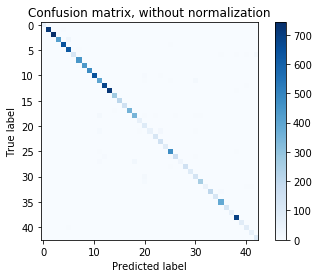

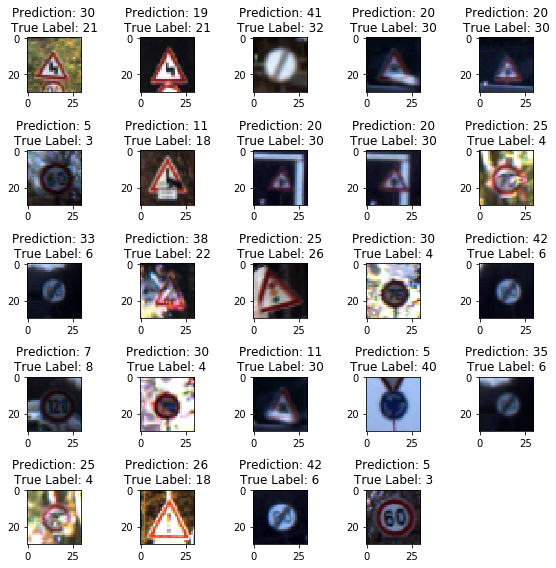

In [8]:
    train_img_path = os.path.join(project_root_dir, 'GTSRB/Final_Training/Images')
    test_img_path = os.path.join(project_root_dir, 'GTSRB/Final_Test/Images')
    train_images, train_labels = get_train_images(train_img_path)
    test_images, test_labels = get_test_images(test_img_path)
    preprocessed_train_images = preprocess_images(train_images, False)
    preprocessed_test_images = preprocess_images(test_images, False)
    traffic_sign_classifier = TrafficSignsClassifier()
    traffic_sign_classifier.train_validation_test_split(np.array(preprocessed_train_images), train_labels, np.array(preprocessed_test_images), test_labels)
    traffic_sign_classifier.build_model()